# Stochastic Gradient Descent on Linear Regression

## 1. Introduction
### The goal of this miniproject is to analyse how to best predict when the gym is likely to be crowded. By doing so an individual can maximize their workout by being less likely to be interupted due to over crowding.

### First determine relevent features and then use the SGDRegressor linear model. This model is fitted by minimizing regularized empirical loss using stochastic gradient descent.

### Afterwards improve model by scaling data and then optimizing parameters. The dataset Crowdedness at the Campus Gym contains the following features:

##### > number_people (number of people at gym at each observation)
##### > date (specific date and time information)
##### > timestamp (number of seconds since the start of the day (00:00))
##### > dayofweek (0 is equal to Monday, 6 to Sunday)
##### > is_weekend (observation during weekend: 1 for yes, 0 for no)
##### > is_holiday (observation during holiday: 1 for yes, 0 for no)
##### > temperature (temp when observation was taken in Fahrenheit)
##### > isstartof_semester (observation during first 2 weeks of semester: 1 for yes, 0 for no)
##### > is_during_semester (observation during active semester: 1 for yes, 0 for no)
##### > month (month of the year: 1 is equal to January, 12 is equal to December)
##### > hour (hour of the day: 0 is equal to 12:00am, 23 is equal to 11:00pm)

In [2]:
# it's time to import!
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler

In [4]:
sns.set_style(style="whitegrid")

# Function used to add labels containing values to top of bars in seaborn barplots
def show_values(axs, orient="v", space=.01):
    def _single(ax):
        if orient == "v":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() / 2
                _y = p.get_y() + p.get_height() + (p.get_height()*0.01)
                value = '{:.3f}'.format(p.get_height())
                ax.text(_x, _y, value, ha="center") 
        elif orient == "h":
            for p in ax.patches:
                _x = p.get_x() + p.get_width() + float(space)
                _y = p.get_y() + p.get_height() - (p.get_height()*0.5)
                value = '{:.3f}'.format(p.get_width())
                ax.text(_x, _y, value, ha="left")

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _single(ax)
    else:
        _single(axs)

In [44]:
# read csv file into pandas dataframe
gym=pd.read_csv('crowdness_gym_data.csv')
gym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62184 entries, 0 to 62183
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   number_people         62184 non-null  int64  
 1   date                  62184 non-null  object 
 2   timestamp             62184 non-null  int64  
 3   day_of_week           62184 non-null  int64  
 4   is_weekend            62184 non-null  int64  
 5   is_holiday            62184 non-null  int64  
 6   temperature           62184 non-null  float64
 7   is_start_of_semester  62184 non-null  int64  
 8   is_during_semester    62184 non-null  int64  
 9   month                 62184 non-null  int64  
 10  hour                  62184 non-null  int64  
dtypes: float64(1), int64(9), object(1)
memory usage: 5.2+ MB


In [45]:
gym.columns

Index(['number_people', 'date', 'timestamp', 'day_of_week', 'is_weekend',
       'is_holiday', 'temperature', 'is_start_of_semester',
       'is_during_semester', 'month', 'hour'],
      dtype='object')

In [46]:
gym.describe()

,number_people,timestamp,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
count,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000,62184.000000
mean,29.072543,45799.437958,2.982504,0.282870,0.002573,58.557108,0.078831,0.660218,7.439824,12.236460
std,22.689026,24211.275891,1.996825,0.450398,0.050660,6.316396,0.269476,0.473639,3.445069,6.717631
min,0.000000,0.000000,0.000000,0.000000,0.000000,38.140000,0.000000,0.000000,1.000000,0.000000
25%,9.000000,26624.000000,1.000000,0.000000,0.000000,55.000000,0.000000,0.000000,5.000000,7.000000
50%,28.000000,46522.500000,3.000000,0.000000,0.000000,58.340000,0.000000,1.000000,8.000000,12.000000
75%,43.000000,66612.000000,5.000000,1.000000,0.000000,62.280000,0.000000,1.000000,10.000000,18.000000
max,145.000000,86399.000000,6.000000,1.000000,1.000000,87.170000,1.000000,1.000000,12.000000,23.000000


## 2. EDA and Cleaning the Data
### Next remove date and timestamp columns; these two columns are redundant due to hour, day_of_week, and month already existing in the dataset.

In [66]:
# drop columns and create new dataframe
gym_modif=gym.drop('timestamp', axis=1)
gym_modif = gym_modif.drop('date', axis=1)

gym_modif.head()

,number_people,day_of_week,is_weekend,is_holiday,temperature,is_start_of_semester,is_during_semester,month,hour
0,37,4,0,0,71.76,0,0,8,17
1,45,4,0,0,71.76,0,0,8,17
2,40,4,0,0,71.76,0,0,8,17
3,44,4,0,0,71.76,0,0,8,17
4,45,4,0,0,71.76,0,0,8,17


In [67]:
gym_modif.columns

Index(['number_people', 'day_of_week', 'is_weekend', 'is_holiday',
       'temperature', 'is_start_of_semester', 'is_during_semester', 'month',
       'hour'],
      dtype='object')

### Initial statistics of the data look fairly reasonable; we have not weired inputs. So the next thing we'll do is look at data distributions of different features.

### 2.1: Data Visualisations

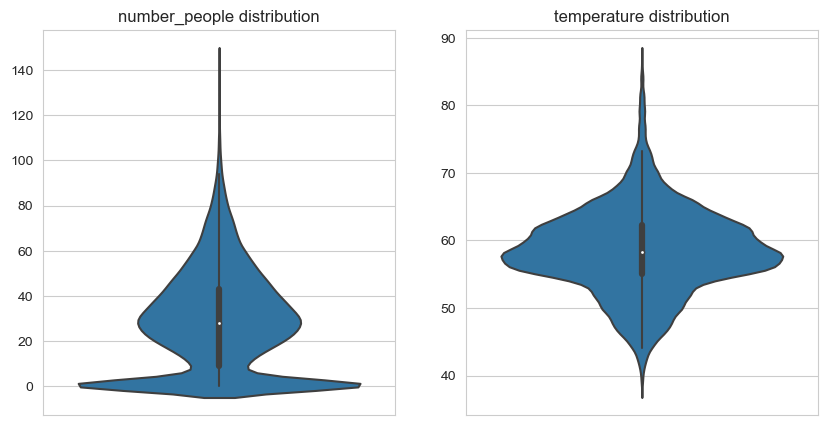

In [68]:
# Let us start by looking at continuous columns/data.

dist_cols=['number_people', 'temperature']

plt.figure(figsize=(10,5))

# Loop to plot violin plots of number_people and temperatures
for i, col in enumerate(dist_cols):
    plt.subplot(1,2,i+1)
    sns.violinplot(data=gym_modif, y=col)
    plt.title(f'{col} distribution')
    plt.ylabel('')
plt.show()  

##### > Number of People : ranging inside interval [0, ~150] with an average of ~30. Seems OK
##### > Temperature distribution : It's obviously in Fahrenheit. Ranging inside interval [30, 90] with an average of ~58. Pretty OK. 

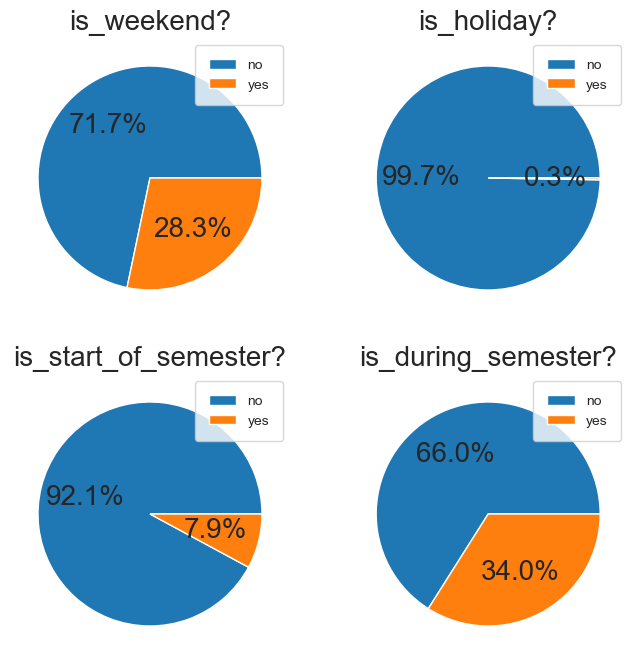

In [69]:
# On we go to discrete columns/data
# pie charts of binary features percentage of the total dataset

yes_no=['is_weekend', 'is_holiday', 'is_start_of_semester', 'is_during_semester']

plt.figure(figsize=(8,8))

for i, cat in enumerate(yes_no):
    plt.subplot(2,2,i+1)
    gym_modif[cat].value_counts(normalize=True).plot.pie(autopct='%1.1f%%', labeldistance=None,textprops={'fontsize': 20})
    plt.title(f'{cat}?', fontsize=20)                                                    
    plt.ylabel('')  
    plt.legend(['no','yes'],fontsize=10, borderpad=1)
plt.show() 

##### > Is it weekend? : Pretty normal numbers
##### > Is it a public holiday? : A vast majority does not show up to work out. Pretty normal considering hte gym might be closed. 
##### > Is it the start of semester? : It looks like it's OK
##### > Is it during semester? : Classes tend to gradually empty as semester goes on. 

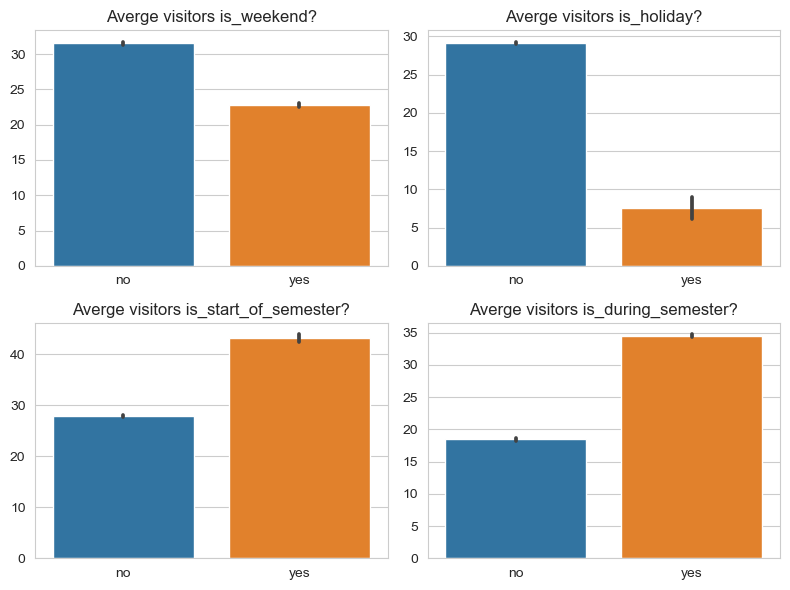

In [70]:
# Let us investigate with some bar charts and average analysis
# bar charts of binary features showing average visitors

plt.figure(figsize=(8,6))
for i, col in enumerate(yes_no):
    plt.subplot(2,2,i+1)
    sns.barplot(data=gym_modif, y='number_people', x=col, orient='v')
    plt.title(f'Averge visitors {col}?')
    plt.xlabel('')
    plt.ylabel('')
    plt.xticks(ticks=[0,1],labels=['no','yes'])
plt.tight_layout()
plt.show()

##### > Average visitors drop from about 32 during the week to about 23 during the weekend
##### > Average visitors drop from about 28 during normal times to only about 8 during holidays. And even still, the deviation gets significantly larger too. 
##### > Average visitors increase to over 40 at the start of a semester
##### > Average visitors during semester are at about 34

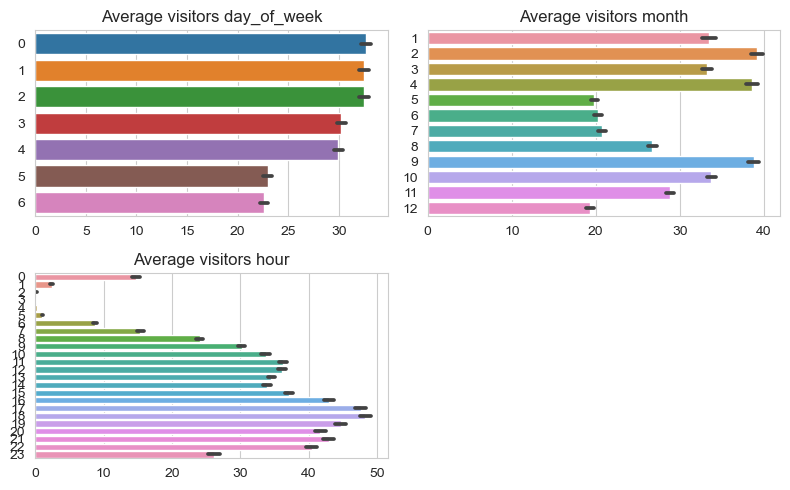

In [71]:
hist=['day_of_week','month', 'hour']

plt.figure(figsize=(8,5))

# create barplots of time related features
for i, col in enumerate(hist):
    plt.subplot(2,2,i+1)
    sns.barplot(data=gym_modif, x='number_people', y=col, orient='h')
    plt.title(f'Average visitors {col}')
    plt.xlabel('')
    plt.ylabel('')
plt.tight_layout()
plt.show() 

##### > Average visitors is pretty steady during the week, but tends to decrease as the week ends. 
##### > Average visitors tend to decrease during the summer months, and during christmas period too. Pretty steady otherwise. 
##### > Average visitors peak during the late afternoon / early evening hours, in a steady pace. Then gradually decrease after that. 

Text(0.5, 1.0, "Pearson's Correlation Chart")

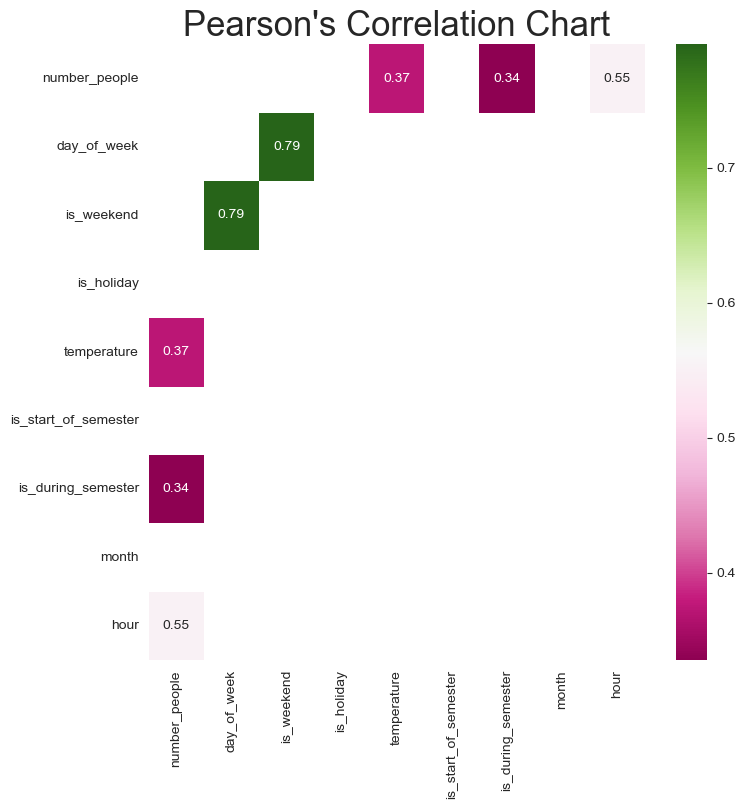

In [72]:
# We'd now need a correlation chart to investigate a potential relationship between the variables. 

corr = abs(gym_modif.corr())

# And of course we proceed to plot correlations on a heatmap
plt.figure(figsize=(8,8))
sns.heatmap(corr[(corr>.25)&(corr<1)], cmap="PiYG", annot=True)
plt.title("Pearson's Correlation Chart", fontsize=25) 

### So let us present a list of strongest to weekest correlations with regards to number_people:
#### 1. hour - 0.55
#### 2. temperature - 0.37
#### 3. is_during_semester - 0.34
#### 4. is_start_of_semester - 0.18
#### 5. is_weekend - 0.17
#### 6. day_of_week - 0.16
#### 7. month - 0.098
#### 8. is_holiday - 0.048

## 3. Building the Model
### We will model the data using a SGDRegressor, i.e a linear model fitted by minimizing a regularized empirical loss with SGD. 
### SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decreasing strength schedule (aka learning rate).
### For the start the default parameters will be used with only random_state chosen for repeatable results.

In [75]:
# break dataset into predictor and outcome datasets

X=gym_modif.drop(columns='number_people')
y=gym_modif['number_people']

# Split data into training and test sets
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.33, random_state=42)

In [76]:
# create SGDRegressor object
sgdr=SGDRegressor(random_state=42)

# train model on the data
sgdr.fit(X_train, y_train)

# make predictions with the model
y_pred=sgdr.predict(X_test)

# print out metrics
mse=mean_squared_error(y_test, y_pred)
score = sgdr.score(X_test, y_test)
iterations = sgdr.n_iter_

print(f'r2 is {score:.3f} with mse of {mse:.3f} with {iterations} iterations')

r2 is -4.315 with mse of 2743.120 with 1000 iterations


C:\Users\geopa\.conda\envs\GSPT\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1548: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(


## 4. Graph Accuracy of the Model
### To visualize the success of the model a scatter plot of predicted values vs actual values will be generated.

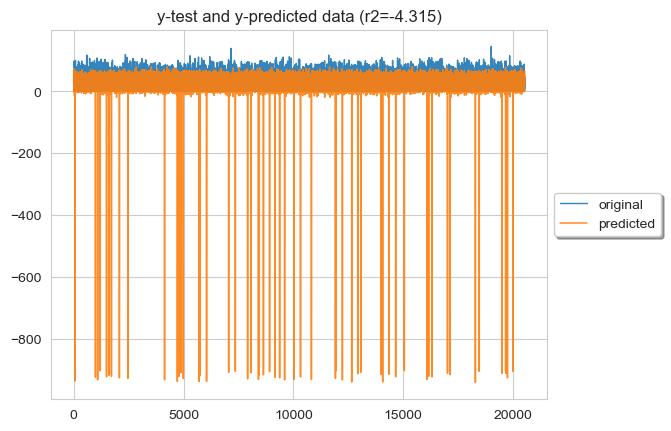

In [77]:
# Create function to create scatter plot of predicted values vs 
def graph_test_accuracy(y_test, y_pred, score):
    x_ax = range(len(y_test))
    plt.plot(x_ax, y_test, linewidth=1, label="original", alpha=0.9)
    plt.plot(x_ax, y_pred, linewidth=1.1, label="predicted", alpha=0.9)
    plt.title(f"y-test and y-predicted data (r2={score:.3f})")
    plt.xlabel('')
    plt.ylabel('')
    plt.legend(fancybox=True, shadow=True, loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show() 

# graph results    
graph_test_accuracy(y_test, y_pred, score) 

## 5. Scaling the Data
### Next to improve accuracy of the model the features in the predictor features in the dataset by normalizing the data to a standard scale.
### StandardScaler scales data based on the standard deviation of the value. If the value is close to zero it means that the data has a very small standard deviation. Higher numbers mean more variance from the mean.

In [78]:
# scaled predictor dataset to standard scale
scaler=StandardScaler()
X_scaled=scaler.fit_transform(X)

# split scaled data to train and test datasets
X_train, X_test, y_train, y_test=train_test_split(X_scaled, y, test_size=0.33, random_state=47)

In [79]:
# create new model object
sgdr=SGDRegressor(random_state=47)

# fit data to model
sgdr.fit(X_train, y_train)

# make predictions using model
y_pred=sgdr.predict(X_test)

# generate metrics
mse=mean_squared_error(y_test, y_pred)
score = sgdr.score(X_test, y_test)
iterations = sgdr.n_iter_

print(f'r2 is {score:.3f} with mse of {mse:.3f} with {iterations} iterations')

r2 is 0.503 with mse of 255.473 with 12 iterations


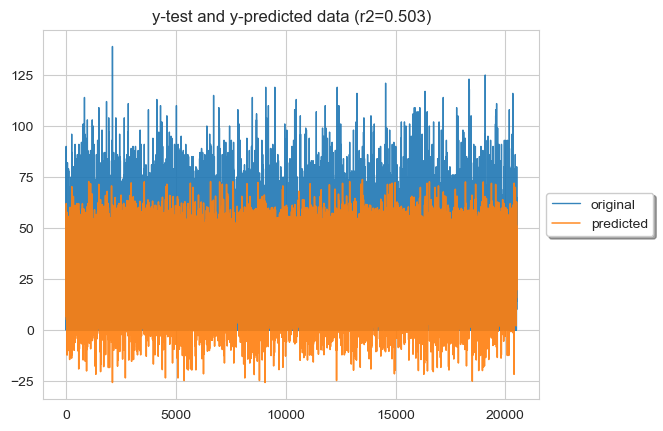

In [81]:
graph_test_accuracy(y_test, y_pred, score)  

## 5. Hyperparameter Tuning
### Next will attempt to improve model by changed parameters. Will concentrate on learning_rate, alpha and eta0 parameters.
##### > learning_rate - Learning Rate Schedule
##### > alpha - Constant that multiplies the regularization term
##### > eta0 - Initial learning rate

Text(0.5, 1.0, 'Accuracy with different learning rate schedules')

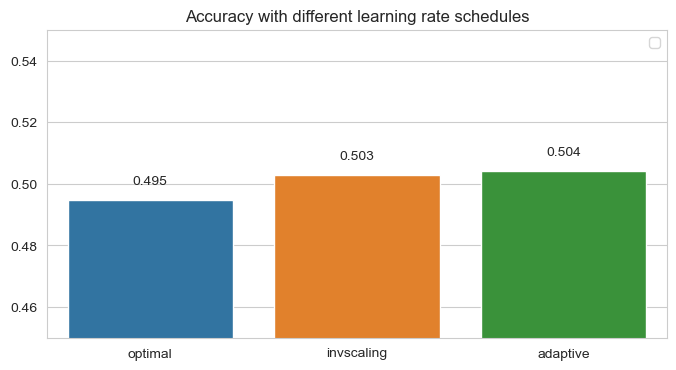

In [82]:
# create list of different learning_rate schedule parameter values and dictionary to store accuracy results
accuracy={}
learning_rate=['optimal', 'invscaling', 'adaptive']

# created loop trying different learning_rate parameters
for rate in learning_rate:
    sgdr=SGDRegressor(random_state=47, learning_rate=rate)
    sgdr.fit(X_train, y_train)
    y_pred=sgdr.predict(X_test)
    mse=mean_squared_error(y_test, y_pred)
    score = sgdr.score(X_test, y_test)
    accuracy[rate]=score

# create bar graph using accuracy dictionary created in prior loop    
plt.figure(figsize=(8,4))    
p=sns.barplot(x=list(accuracy.keys()), y=list(accuracy.values()))
show_values(p)
plt.legend('')
plt.ylim(0.45,0.55)
plt.title('Accuracy with different learning rate schedules')

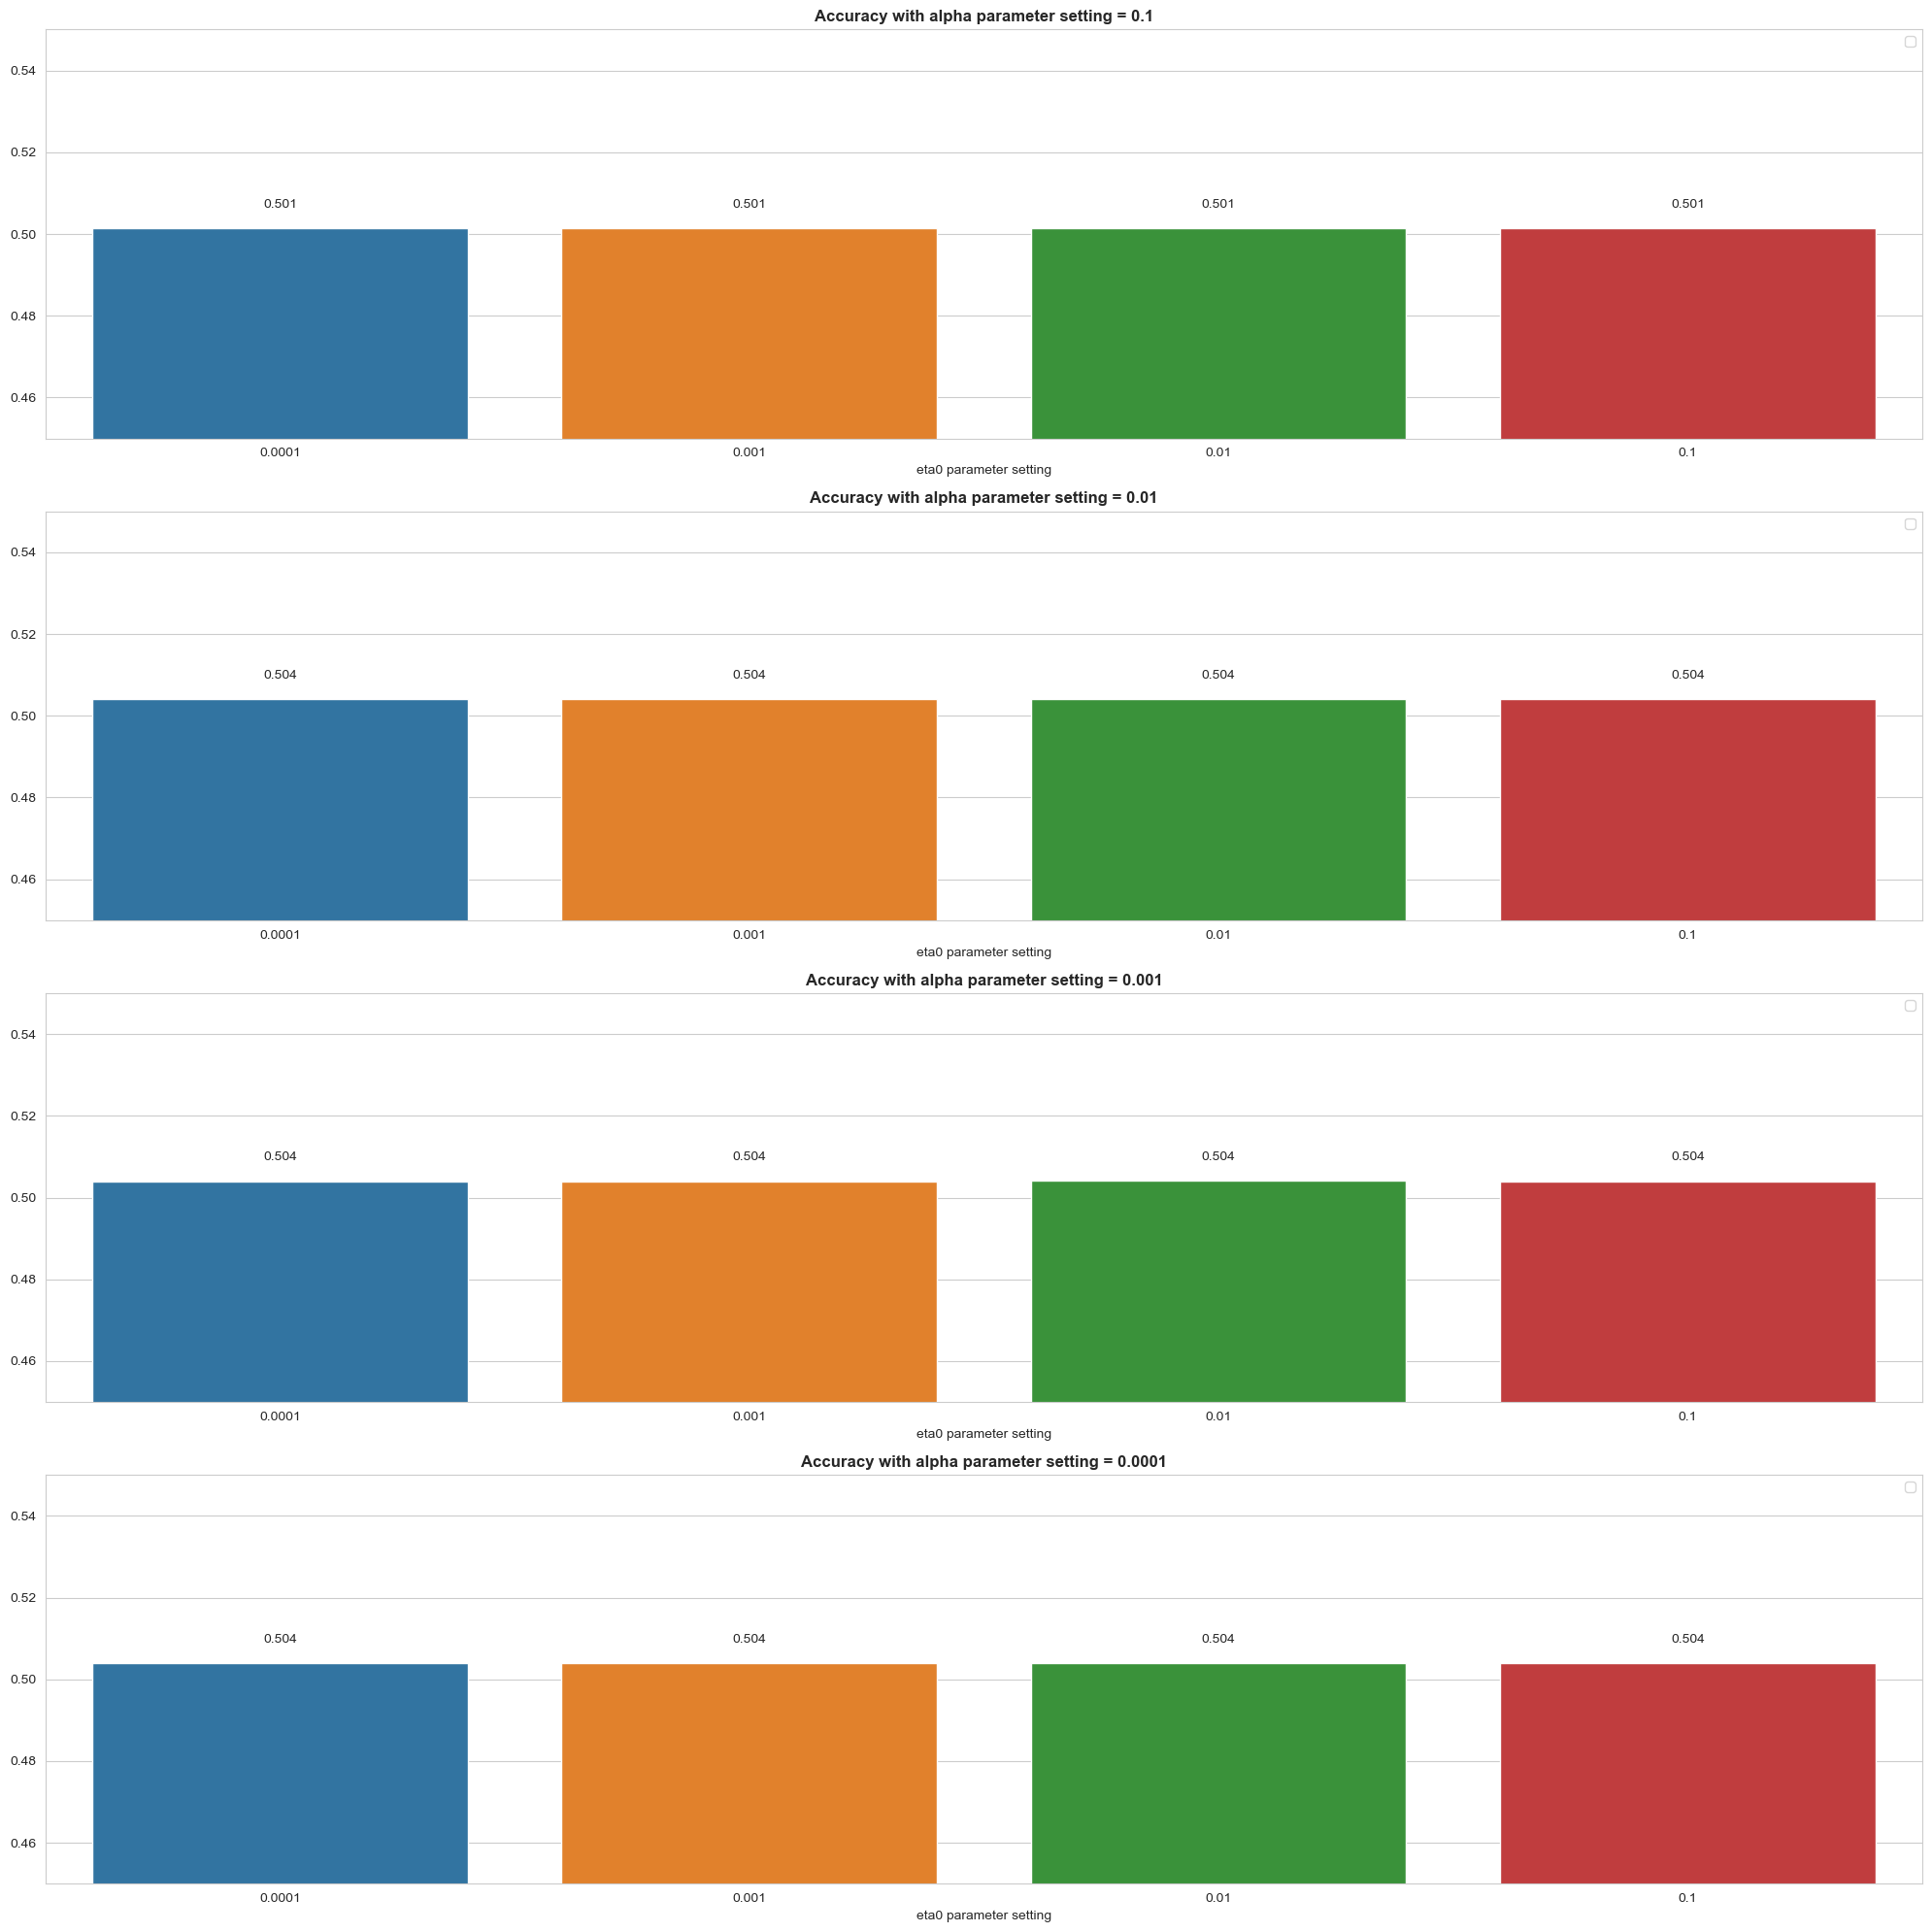

In [83]:
# Results show that adaptive setting is best schedule for learning_rate parameter.

# crated list of different parameter values for alpha and eta0.  
alpha_eta=[0.1, .01, 0.001, 0.0001]

plt.figure(figsize=(20,20))

# create nested loop for different values of alpha and eta0 parameters
for a, par in enumerate(alpha_eta):
    accuracy={}
    for e in alpha_eta:
        sgdr=SGDRegressor(max_iter=10000, random_state=47, learning_rate='adaptive', alpha=par, eta0=e)
        sgdr.fit(X_train, y_train)
        y_pred=sgdr.predict(X_test)
        mse=mean_squared_error(y_test, y_pred)
        score = sgdr.score(X_test, y_test)
        accuracy[e]=score

# Plot accuracy dictionary generated above         
    plt.subplot(4,1,a+1)
    p=sns.barplot(x=list(accuracy.keys()), y=list(accuracy.values()))
    show_values(p)
    plt.legend('')
    plt.ylim(0.45,0.55)
    plt.title(f'Accuracy with alpha parameter setting = {par}', weight='bold')
    plt.xlabel('eta0 parameter setting')
    plt.tight_layout()

### There was no substantial differences in the accuracy scores. Results range from 0.501 to 0.504.
### There does not seem to be any significant improvement in the accuracy scores. However, accuracy is not the only important metric in a model. Efficent models are also important.
### If a model is slow, the model will take more resources whether it be computing power or just the time itself that could be used for other work. This is not an issue for relatively small datsets such as this one, but could be an issue in larger datasets.
### Will run alpha/eta0 parameter check, but capturing total iterations instead of accuracy.

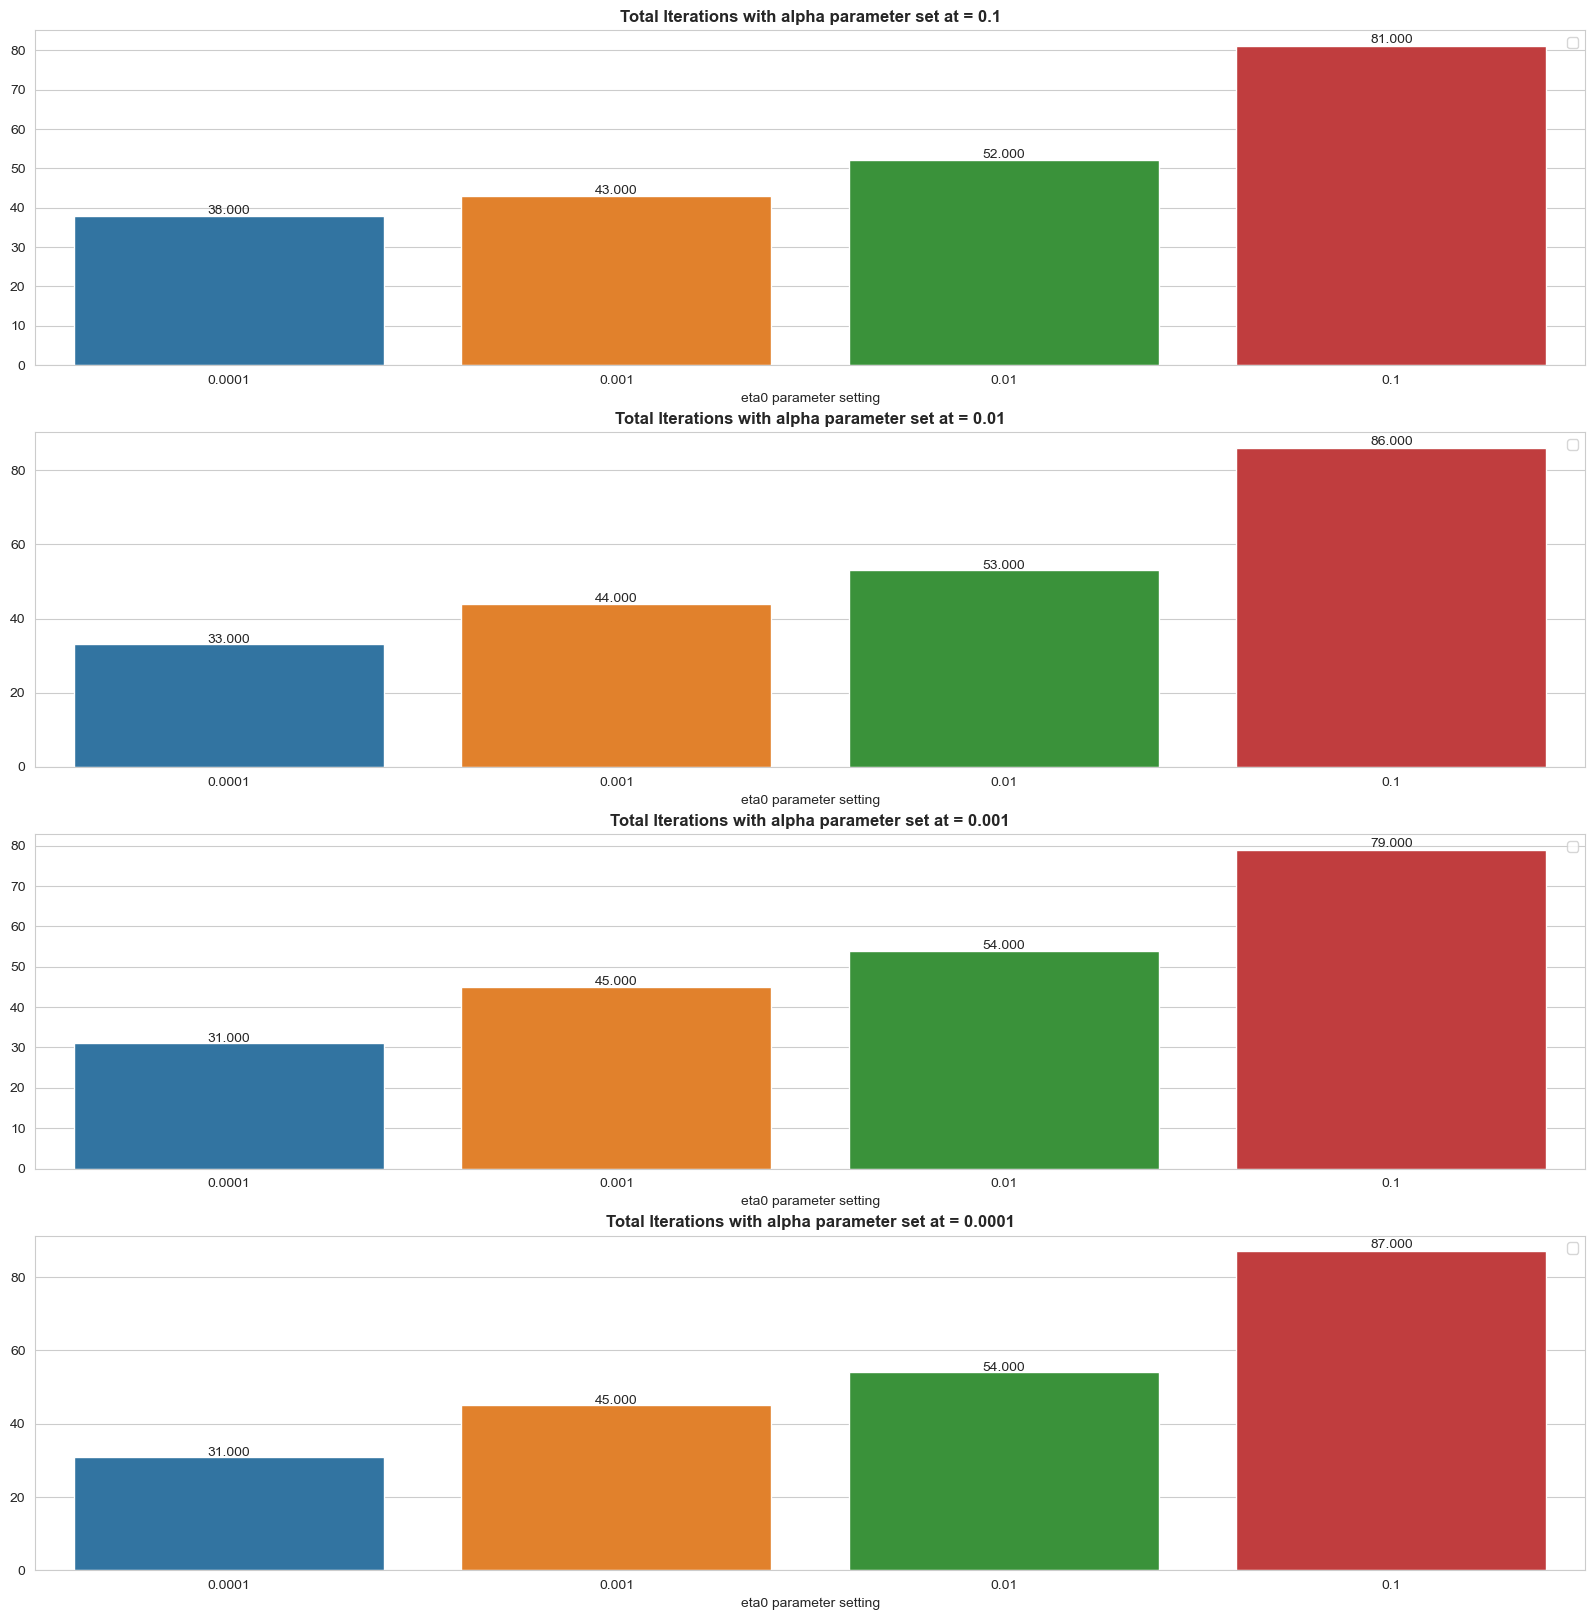

In [84]:
alpha_eta=[0.1, .01, 0.001, 0.0001]

plt.figure(figsize=(20,20))

# rerun and capture total iterations
for a, par in enumerate(alpha_eta):    
    iterations={}
    for e in alpha_eta:
        sgdr=SGDRegressor(random_state=47, learning_rate='adaptive', alpha=par, eta0=e)
        sgdr.fit(X_train, y_train)
        y_pred=sgdr.predict(X_test)
        iterations[e]=sgdr.n_iter_
        
    plt.subplot(4,1,a+1)
    p=sns.barplot(x=list(iterations.keys()), y=list(iterations.values()))
    show_values(p)
    plt.legend('')
    plt.title(f'Total Iterations with alpha parameter set at = {par}', weight='bold')
    plt.xlabel('eta0 parameter setting')

### Going off of the total iterations as accuracy is more or less equal. The optimum parameters:
##### > alpha = 0.001
##### > eta0 = 0.0001

## 6. Final Model
### Create final model with improved parameters and plot the results.

In [85]:
# create sgdr object
sgdr=SGDRegressor(max_iter=10000, random_state=47, learning_rate='adaptive', alpha=0.001, eta0=0.0001)

# fit data to model
sgdr.fit(X_train, y_train)

# make predictions with model
y_pred=sgdr.predict(X_test)

# metrics of model
mse=mean_squared_error(y_test, y_pred)
score = sgdr.score(X_test, y_test)
iterations = sgdr.n_iter_
b=sgdr.intercept_

print(f'r2 is {score:.3f} with mse of {mse:.3f} with {iterations} iterations')
coef_df=pd.DataFrame(sgdr.coef_, index=X.columns, columns=['coef'])
coef_df

r2 is 0.504 with mse of 254.901 with 31 iterations


,coef
day_of_week,-1.779990
is_weekend,-2.292344
is_holiday,-0.627858
temperature,5.529237
is_start_of_semester,1.825008
is_during_semester,6.018933
month,-2.606443
hour,11.157636


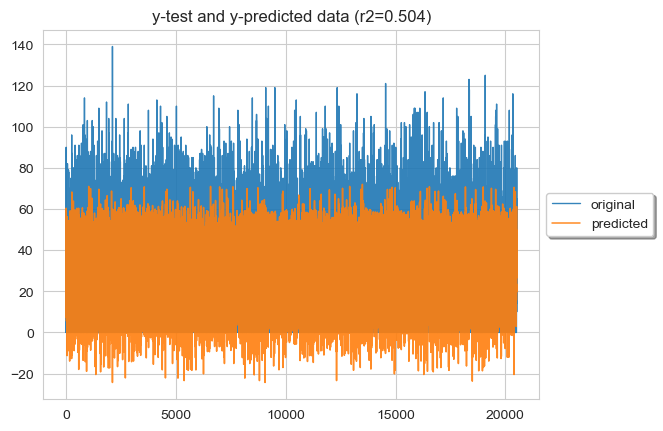

In [86]:
graph_test_accuracy(y_test, y_pred, score)


Text(0.5, 1.0, 'linear plots based on features used in model')

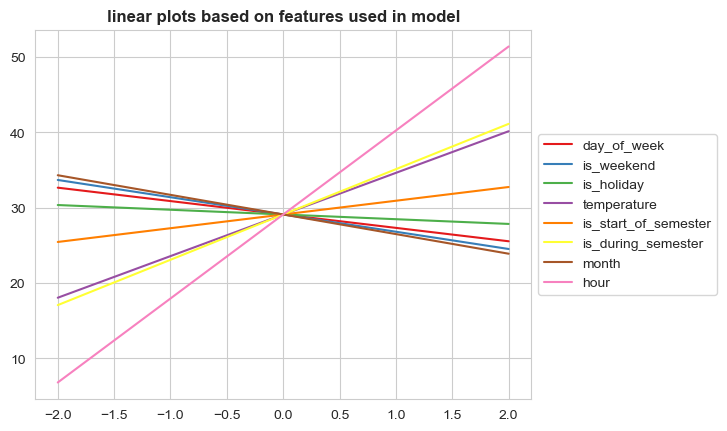

In [87]:
# Predicted values tend to screw lower than the actual ones.

# graph features by model coefficients and intercept
colors=sns.color_palette('Set1')
coef=sgdr.coef_

x=np.linspace(-2,2,1000)

for i, col in enumerate(X.columns):
    y=coef[i]*x+b
    plt.plot(x,y,label=col, color=colors[i])

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('linear plots based on features used in model', weight='bold') 

### Hour, is_during_semester, and temperature tend to be strongly positively correlated to increased attendance. 
### Month, weekend, and day_of_week tend to have a moderate negative correlation to attendance.

## 7. Conclusion
### Overall Results:
#### > Non-Scaled data - r2 is 0.481 with mse of 266.804 with 972 iterations
#### > Scaled data - r2 is 0.503 with mse of 255.473 with 12 iterations
#### > Optimized parameters with scaled data - r2 is 0.504 with mse of 254.901 with 31 iterations
#### > Scaling the data led to the greatest imporovement in accuracy and total number of iterations.
#### > There was little improvement with optimizing the parameters.

### The strongest coefficients in the model were hour, is_during_semester and temperature.
### Overall the gym is busiest late in the day and visits slowly go down as the week goes on with a dip in attendence during the weekends.